In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [101]:
def plot_navigation(position_arr, feeder_position, state_change_time):
    position_arr = position_arr
    feeder_position = feeder_position
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    ax.plot(position_arr[:state_change_time,0], position_sequence[:state_change_time,1])
    ax.plot(position_arr[state_change_time:,0], position_sequence[state_change_time:,1])
    ax.scatter(np.array([0]), np.array([0]), c="#000000")
    ax.scatter(feeder_position[0], feeder_position[1], c="#00FF00")
    ax.set_aspect("equal")
    plt.show()

In [122]:
class AdaptiveVectorNavigation():
    def __init__(self, 
                 forage_time: int, 
                 num_neurons: int,
                 leak_rate  : float) -> None:
        # self.feeder_position = 5 * np.random.randn(2) # TODO: follow eqs 25, 26, 27
        self.feeder_position = np.array([0, 3])
        self.time = 0
        self.forage_time = forage_time
        self.reward_threshold = 0.5

        # self.phi               = np.zeros((1,))
        # print(f"phi: {self.phi}")
        self.phi               = 0
        self.speed             = 0.5
        self.state             = 1 # outward trip initially
        self.position          = np.zeros((2,)) # (x,y)
        self.rewards           = 0
    
        self.neuron_phi            = (2 * np.pi / num_neurons) * np.arange(num_neurons)
        self.cosine_kernel         = np.empty((num_neurons, num_neurons))
        for i in range(num_neurons):
            for j in range(num_neurons):
                self.cosine_kernel[i,j] = np.cos(self.neuron_phi[i] - self.neuron_phi[j])
        # self.decoding_layer           = np.zeros((num_neurons,))
        self.memory_layer             = np.random.randn(num_neurons)
        self.leak_rate                = leak_rate
        self.home_vector              = np.zeros((num_neurons,))
        self.global_weights           = np.random.randn(num_neurons)
        self.inverse_temp_exploration = 1e-5 # guess at a good initial value
        self.lpf_food_reward          = np.zeros((1,))
        
    def relu(self, x, /):
        return x * (x > 0)

    def update_home_vector(self) -> None:
        head_layer = np.cos(self.phi - self.neuron_phi)
        # head_layer = np.clip(head_layer, 0, None)
        gating_layer = self.relu(head_layer - 1 + self.speed)
        # gating_layer = np.clip(gating_layer, 0, None)
        self.memory_layer = self.relu(gating_layer + ((1 - self.leak_rate) * self.memory_layer))
        # self.memory_layer = np.clip(self.memory_layer, 0, None)
        self.decoding_layer = self.relu(np.matmul(self.cosine_kernel, self.memory_layer)) # actually the head vector
        # self.decoding_layer = np.clip(self.decoding_layer, 0, None)
        # print(f"head vector: {self.decoding_layer}")
        self.head_vector_angle = np.arctan((np.dot(self.decoding_layer, np.sin(self.neuron_phi)) / np.dot(self.decoding_layer, np.cos(self.neuron_phi))))
        # self.head_vector_angle = np.clip(self.head_vector_angle, 0, 2*np.pi)
        # print(f"hv angle: {self.head_vector_angle}")
        # head_vector_length = np.sum(self.decoding_layer) # could be incorrect implementation, hard to understand article
        # head_vector_length = np.dot(self.decoding_layer, self.neuron_phi)
        head_vector_length = np.sqrt((np.dot(self.decoding_layer, np.sin(self.neuron_phi)) ** 2) + (np.dot(self.decoding_layer, np.cos(self.neuron_phi)) ** 2))
        # self.speed += head_vector_length
        self.motor_hv = head_vector_length * np.sin(self.head_vector_angle - self.phi - np.pi)
        self.motor_hv = np.clip(self.motor_hv, 0, None)

    def update_global_vector(self) -> None:
        if ((self.time >= self.forage_time) or (self.rewards >= self.reward_threshold)) and self.state: # inward/outward trip
            self.state_change_time = self.time
            self.state = 0
            # print("swapped state!!")
        self.rewards = self.relu(1 - 5 * np.linalg.norm(self.feeder_position - self.position))
        # print(f"rewards: {self.rewards}")
        # print(f"state: {self.state}")

        global_vector = self.state * self.global_weights
        # global_vector = np.clip(global_vector, 0, None)
        delta_global_weights = 2 * self.rewards * self.state * (self.decoding_layer - global_vector) # equation 14 and 15. 
        self.global_weights += delta_global_weights
        # print("gv", global_vector)
        # print("gw", self.global_weights)
        # print("dgw", delta_global_weights)
            
        if self.state:
            global_vector_angle = np.arctan(np.dot(global_vector, np.sin(self.neuron_phi)) / np.dot(global_vector , np.cos(self.neuron_phi)))
            # global_vector_angle = np.clip(global_vector_angle, 0, 2*np.pi)
            # global_vector_length = np.sum(global_vector)
            # global_vector_length = np.dot(global_vector, self.neuron_phi)
            global_vector_length = np.sqrt((np.dot(global_vector, np.sin(self.neuron_phi)) ** 2) + (np.dot(global_vector , np.cos(self.neuron_phi)) ** 2))
            # self.speed += global_vector_length
            # print(f"global vec angle/length: {global_vector_angle, global_vector_length}")
            self.motor_gv = global_vector_length * np.sin(global_vector_angle - self.phi) #todo: global vector angle?
            self.motor_gv = np.clip(self.motor_gv, 0, None)

    def update_navigation(self) -> None:
        # self.speed = 0
        self.update_home_vector()
        self.update_global_vector()

        # update exploration and navigation
        exploration_rate = self.state * np.exp(-self.inverse_temp_exploration * self.lpf_food_reward)
        exploration_rate = np.clip(exploration_rate, 0, 1)
        random_search = np.random.normal(0.0, exploration_rate)
        self.lpf_food_reward = self.rewards + 0.995 * self.lpf_food_reward
        # print(f"lpf food reward: {self.lpf_food_reward}")
        self.inverse_temp_exploration += 1e-6 * ((1 / self.inverse_temp_exploration) + (100 * self.lpf_food_reward * exploration_rate))
        # print(f"inverse temp of exploration {self.inverse_temp_exploration}")
        motor_command = (1 - exploration_rate) * ((self.state * self.motor_gv) + self.motor_hv) + random_search
        # print(f"motor command: {motor_command}")
        # print(f"motor gv/hv: {self.motor_gv, self.motor_hv}")

        # update position due to control input
        self.previous_position = self.position.copy()
        self.phi += 0.1 * np.pi * motor_command # 0.1 = Delta t
        if self.phi > np.pi:
            self.phi -= 2 * np.pi
        elif self.phi < -np.pi:
            self.phi += 2 * np.pi
        # print(f"phi: {self.phi}")
        self.position[0] += np.squeeze(0.1 * self.speed * np.cos(self.phi))
        self.position[1] += np.squeeze(0.1 * self.speed * np.sin(self.phi))
        # print(f"position: {self.position}")

        self.time = self.time + 1

In [126]:
graph_test_navigation = AdaptiveVectorNavigation(1000, 18, 0.0075)

In [127]:
position_sequence = np.empty((1200, 2))
position_sequence[0] = graph_test_navigation.position
for i in range(1199):
    graph_test_navigation.update_navigation()
    position_sequence[i+1] = graph_test_navigation.position
    if i % 100 == 0:
        print(f"-------------------------\ndone with time step {i+1}")

-------------------------
done with time step 1
-------------------------
done with time step 101
-------------------------
done with time step 201
-------------------------
done with time step 301
-------------------------
done with time step 401
-------------------------
done with time step 501
-------------------------
done with time step 601
-------------------------
done with time step 701
-------------------------
done with time step 801
-------------------------
done with time step 901
-------------------------
done with time step 1001
-------------------------
done with time step 1101


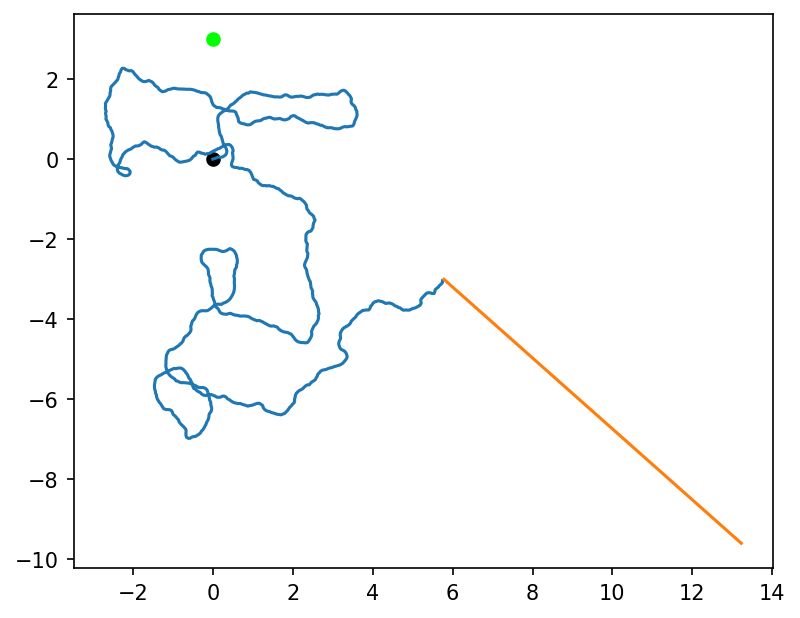

In [128]:
plot_navigation(position_sequence, graph_test_navigation.feeder_position, graph_test_navigation.state_change_time)